# Modelo para la Ciudad de Bogotá

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [13]:
import glob
import os
if (os.path.isfile("LocalConfig/config.json")):
    with open("LocalConfig/config.json") as json_config:
        data = json.load(json_config)
        print(data)
    

In [5]:
ciudades = ['Bogotá D.C.','Medellín','Cali','Barranquilla', 'Cartagena de Indias']
names = ['Bogota','Medellin','Cali','Barranquilla','Cartagena']
id_city= 1
name = names[id_city]
urlDataSet = 'Datos/data_{}.pickle'.format(name)

In [108]:
##Sección de código para ejecutar el ejercicio en COLAB sin realizar ningún cambio adicional.
#from google.colab import drive
#drive.mount('/content/drive')
#baseUrl = '/content/drive/Shared drives/Analitica Predictiva/covid-19-flr-analitica-predictiva'
#os.chdir(baseUrl)

Librerias requeridas para realizar los modelos.

In [2]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Modelo Corto Plazo

Se carga el dataset generado en la sección de preprocesamiento, se muestran los últimos 20 registros, para validar visualmente los ultimos días de información.

In [110]:
urlDatasetMED = 'Datos/data_Medellin.pickle'
dfMED = pd.read_pickle(urlDatasetMED)
dfMED.tail(20)

,dias,semana,infectados,recuperados,muertos,acumulado_infectados,acumulado_recuperados,acumulado_muertos,activos
fecha_infeccioso,,,,,,,,,
2020-08-13,166,23,829.0,1075.0,18.0,42425.0,15497.0,657.0,26271.0
2020-08-14,167,23,827.0,1028.0,22.0,43252.0,16525.0,679.0,26048.0
2020-08-15,168,24,716.0,1543.0,36.0,43968.0,18068.0,715.0,25185.0
2020-08-16,169,24,734.0,1454.0,20.0,44702.0,19522.0,735.0,24445.0
2020-08-17,170,24,640.0,1578.0,19.0,45342.0,21100.0,754.0,23488.0
2020-08-18,171,24,515.0,1095.0,21.0,45857.0,22195.0,775.0,22887.0
2020-08-19,172,24,354.0,1728.0,21.0,46211.0,23923.0,796.0,21492.0
2020-08-20,173,24,369.0,1512.0,20.0,46580.0,25435.0,816.0,20329.0
2020-08-21,174,24,330.0,1050.0,25.0,46910.0,26485.0,841.0,19584.0


### Activos

Para la predicción de casos activos se usó una Regressión Lasso con caracteristicas Polinomiales de grado 5; previamente se estandarizaron los datos, y se entrenaron con un conjunto del 70% de los datos; estos datos se toman aleatoriamente, pero al graficarlos se orden en secuencia.

In [256]:
totalDays = len(dfMED['dias'].values)
X = dfMED['dias'].values[0:totalDays-5].reshape(-1,1) #Variable independiente.
y = dfMED['activos'].values[0:totalDays-5].reshape(-1,1) #Variable dependiente.
#Datos de validación - nunca entran al modelo.
X_v = dfMED['dias'].values[totalDays-5:].reshape(-1,1)
y_v = dfMED['activos'].values[totalDays-5:].reshape(-1,1)
#Se obtiene el 70% para entrenamiento y 30% para pruebas.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123,shuffle=True)
#Se crea un pipeline con el escalado, las caracteristicas polinomiales y la regresión lasso
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(degree=5),Lasso(random_state=123))
#Se realiza el entrenamiento.
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=5, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lasso',
                 Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=123, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

Se realizan las predicciones sobre el dataset de pruebas, adicionalmente se establece el pico en el día 175, por lo cual para fines de prueba se realizan predicciones desde dicho día, hasta el día 200 de la pandemia, para probar la predicción futura de los modelos a corto plazo.

In [257]:
#Obtener predicciones para los datos de prueba.
y_pred = pipe.predict(X_test)
#Predicciones futuras.
x_pred_future = np.arange(totalDays-10,totalDays,step=1)
y_pred_future = pipe.predict(x_pred_future.reshape(-1,1))

Se grafican los datos.

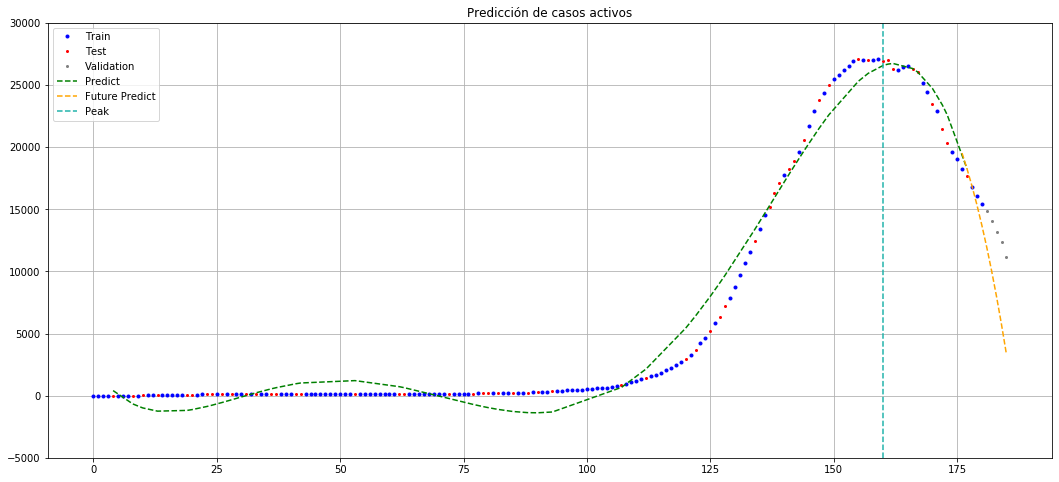

In [258]:
f = plt.figure(figsize=(18,8))
plt.title('Predicción de casos activos')
plt.grid()
plt.plot(X_train[X_train.flatten().argsort(),0],y_train[X_train.flatten().argsort(),0],'ob',markersize=3,label='Train')
plt.plot(X_test[X_test.flatten().argsort(),0],y_test[X_test.flatten().argsort(),0],'or',markersize=2,label='Test')
plt.plot(X_v,y_v,'o',color='gray',markersize=2,label='Validation')
plt.plot(X_test[X_test.flatten().argsort(),0],y_pred[X_test.flatten().argsort()],'--g',label='Predict')
plt.plot(x_pred_future,y_pred_future,'--',color='orange',label='Future Predict')
plt.plot([160,160],[-5000,30000],'--',color='lightseagreen', label='Peak') #Peak of cases.
plt.ylim(-5000,30000)
plt.legend(loc='upper left');

Se calculan las métricas de la regresión, en este caso se calculan las metricas completas sobre el conjunto de prueba, adicionalmente se computan las metricas solo desde el pico en adelante como indicar de las predicciones futuras.

In [259]:
y_pred_val = pipe.predict(X_v)
print('     ---- Métricas ----')
print('Total RMSE:\t\t{:.0f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('Total MAE:\t\t{:.0f}'.format(mean_absolute_error(y_test,y_pred)))
print('Future (5 days) RMSE:\t{:.0f}'.format(np.sqrt(mean_squared_error(y_v, y_pred_val))))
print('Future (5 days) MAE:\t{:.0f}'.format(mean_absolute_error(y_v,y_pred_val)))

     ---- Métricas ----
Total RMSE:		1295
Total MAE:		1044
Future (5 days) RMSE:	5613
Future (5 days) MAE:	5331


### Recuperados
Para la predicción de casos recuperados se usó una Regressión Lasso con caracteristicas Polinomiales de grado 4; previamente se estandarizaron los datos, y se entrenaron con un conjunto del 70% de los datos; estos datos se toman aleatoriamente, pero al graficarlos se orden en secuencia.

In [241]:
totalDays = len(dfMED['dias'].values)
X = dfMED['dias'].values[0:totalDays-5].reshape(-1,1) #Variable independiente.
y = dfMED['acumulado_recuperados'].values[0:totalDays-5].reshape(-1,1) #Variable dependiente.
#Datos de validación - nunca entran al modelo.
X_v = dfMED['dias'].values[totalDays-5:].reshape(-1,1)
y_v = dfMED['acumulado_recuperados'].values[totalDays-5:].reshape(-1,1)
#Se obtiene el 70% para entrenamiento y 30% para pruebas.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123,shuffle=True)
#Se crea un pipeline con el escalado, las caracteristicas polinomiales y la regresión lasso
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(degree=4),Lasso(random_state=123))
#Se realiza el entrenamiento.
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=4, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lasso',
                 Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=123, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

Se realizan las predicciones sobre el dataset de pruebas, adicionalmente se establece el pico en el día 175, por lo cual para fines de prueba se realizan predicciones desde dicho día, hasta el día 200 de la pandemia, para probar la predicción futura de los modelos a corto plazo.

In [242]:
#Obtener predicciones para los datos de prueba.
y_pred = pipe.predict(X_test)
#Predicciones futuras.
x_pred_future = np.arange(totalDays-10,totalDays,step=1)
y_pred_future = pipe.predict(x_pred_future.reshape(-1,1))

Se grafican los datos.

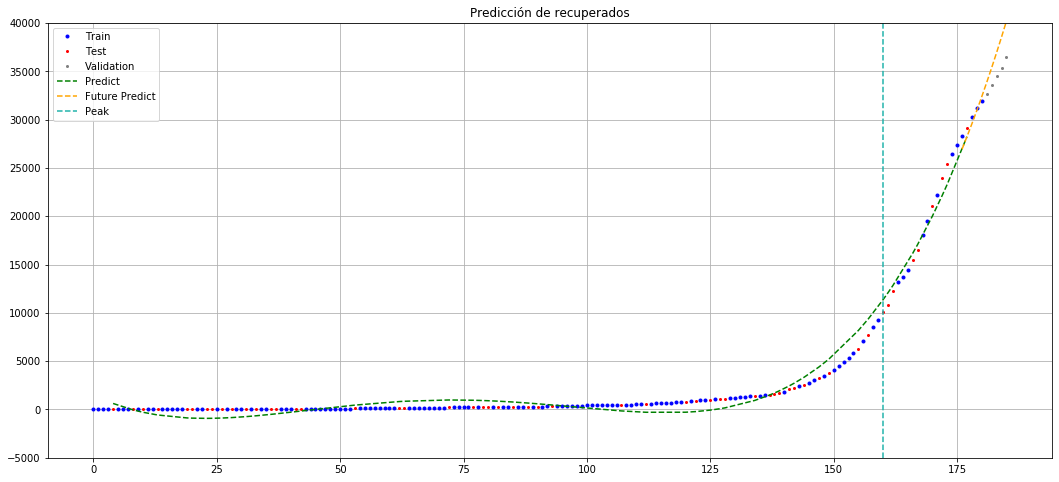

In [246]:
f = plt.figure(figsize=(18,8))
plt.title('Predicción de recuperados')
plt.grid()
plt.plot(X_train[X_train.flatten().argsort(),0],y_train[X_train.flatten().argsort(),0],'ob',markersize=3,label='Train')
plt.plot(X_test[X_test.flatten().argsort(),0],y_test[X_test.flatten().argsort(),0],'or',markersize=2,label='Test')
plt.plot(X_v,y_v,'o',color='gray',markersize=2,label='Validation')
plt.plot(X_test[X_test.flatten().argsort(),0],y_pred[X_test.flatten().argsort()],'--g',label='Predict')
plt.plot(x_pred_future,y_pred_future,'--',color='orange',label='Future Predict')
plt.plot([160,160],[-5000,50000],'--',color='lightseagreen', label='Peak') #Peak of cases.
plt.ylim(-5000,40000)
plt.legend(loc='upper left');

Se calculan las métricas de la regresión, en este caso se calculan las metricas completas sobre el conjunto de prueba, adicionalmente se computan las metricas solo desde el pico en adelante como indicar de las predicciones futuras.

In [247]:
y_pred_val = pipe.predict(X_v)
print('     ---- Métricas ----')
print('Total RMSE:\t\t{:.0f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('Total MAE:\t\t{:.0f}'.format(mean_absolute_error(y_test,y_pred)))
print('Future (5 days) RMSE:\t{:.0f}'.format(np.sqrt(mean_squared_error(y_v, y_pred_val))))
print('Future (5 days) MAE:\t{:.0f}'.format(mean_absolute_error(y_v,y_pred_val)))

     ---- Métricas ----
Total RMSE:		882
Total MAE:		761
Future (5 days) RMSE:	2620
Future (5 days) MAE:	2458


### Muertes
Para la predicción de las muertes se usó una Regressión Lasso con caracteristicas Polinomiales de grado 6; previamente se estandarizaron los datos, y se entrenaron con un conjunto del 70% de los datos; estos datos se toman aleatoriamente, pero al graficarlos se orden en secuencia.

In [236]:
totalDays = len(dfMED['dias'].values)
X = dfMED['dias'].values[0:totalDays-5].reshape(-1,1) #Variable independiente.
y = dfMED['acumulado_muertos'].values[0:totalDays-5].reshape(-1,1) #Variable dependiente.
#Datos de validación - nunca entran al modelo.
X_v = dfMED['dias'].values[totalDays-5:].reshape(-1,1)
y_v = dfMED['acumulado_muertos'].values[totalDays-5:].reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123,shuffle=True)
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(degree=6),Lasso(random_state=123,max_iter=10000))
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=6, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lasso',
                 Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=10000, normalize=False, positive=False,
                       precompute=False, random_state=123, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [239]:
y_pred = pipe.predict(X_test)
x_pred_future = np.arange(totalDays-10,totalDays,step=1)
y_pred_future = pipe.predict(x_pred_future.reshape(-1,1))

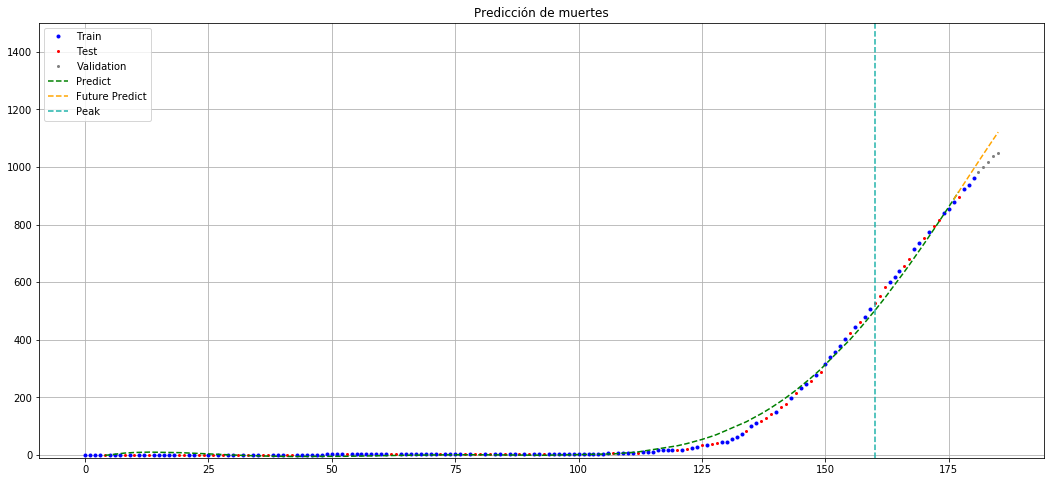

In [240]:
#Graph ordered data.
f = plt.figure(figsize=(18,8))
plt.title('Predicción de muertes')
plt.grid()
plt.plot(X_train[X_train.flatten().argsort(),0],y_train[X_train.flatten().argsort(),0],'ob',markersize=3,label='Train')
plt.plot(X_test[X_test.flatten().argsort(),0],y_test[X_test.flatten().argsort(),0],'or',markersize=2,label='Test')
plt.plot(X_v,y_v,'o',color='gray',markersize=2,label='Validation')
plt.plot(X_test[X_test.flatten().argsort(),0],y_pred[X_test.flatten().argsort()],'--g',label='Predict')
plt.plot(x_pred_future,y_pred_future,'--',color='orange',label='Future Predict')
plt.plot([160,160],[-10,1500],'--',color='lightseagreen', label='Peak') #Peak of cases.
plt.ylim(-10,1500)
plt.legend(loc='upper left');

In [122]:
y_pred_val = pipe.predict(X_v)
print('     ---- Métricas ----')
print('Total RMSE:\t\t{:.0f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('Total MAE:\t\t{:.0f}'.format(mean_absolute_error(y_test,y_pred)))
print('Future (5 days) RMSE:\t{:.0f}'.format(np.sqrt(mean_squared_error(y_v, y_pred_val))))
print('Future (5 days) MAE:\t{:.0f}'.format(mean_absolute_error(y_v,y_pred_val)))

     ---- Métricas ----
Total RMSE:		15
Total MAE:		12
Future (5 days) RMSE:	54
Future (5 days) MAE:	52


### Infectados
Para la predicción de los infectados se usó una Regressión Lasso con caracteristicas Polinomiales de grado 4; previamente se estandarizaron los datos, y se entrenaron con un conjunto del 70% de los datos; estos datos se toman aleatoriamente, pero al graficarlos se orden en secuencia.

In [228]:
totalDays = len(dfMED['dias'].values)
X = dfMED['dias'].values[0:totalDays-5].reshape(-1,1) #Variable independiente.
y = dfMED['acumulado_infectados'].values[0:totalDays-5].reshape(-1,1) #Variable dependiente.
#Datos de validación - nunca entran al modelo.
X_v = dfMED['dias'].values[totalDays-5:].reshape(-1,1)
y_v = dfMED['acumulado_infectados'].values[totalDays-5:].reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123,shuffle=True)
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(degree=5),Lasso(random_state=123))
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=5, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lasso',
                 Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=123, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [233]:
y_pred = pipe.predict(X_test)
x_pred_future = np.arange(totalDays-10,totalDays,step=1)
y_pred_future = pipe.predict(x_pred_future.reshape(-1,1))

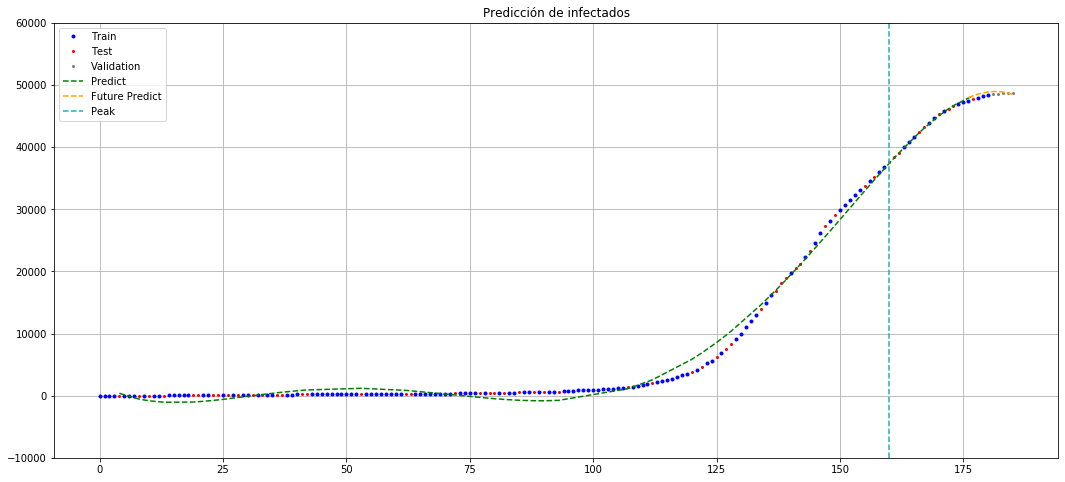

In [234]:
#Graph ordered data.
f = plt.figure(figsize=(18,8))
plt.title('Predicción de infectados')
plt.grid()
plt.plot(X_train[X_train.flatten().argsort(),0],y_train[X_train.flatten().argsort(),0],'ob',markersize=3,label='Train')
plt.plot(X_test[X_test.flatten().argsort(),0],y_test[X_test.flatten().argsort(),0],'or',markersize=2,label='Test')
plt.plot(X_v,y_v,'o',color='gray',markersize=2,label='Validation')
plt.plot(X_test[X_test.flatten().argsort(),0],y_pred[X_test.flatten().argsort()],'--g',label='Predict')
plt.plot(x_pred_future,y_pred_future,'--',color='orange',label='Future Predict')
plt.plot([160,160],[-10000,60000],'--',color='lightseagreen', label='Peak') #Peak of cases.
plt.ylim(-10000,60000)
plt.legend(loc='upper left');

In [235]:
y_pred_val = pipe.predict(X_v)
print('     ---- Métricas ----')
print('Total RMSE:\t\t{:.0f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('Total MAE:\t\t{:.0f}'.format(mean_absolute_error(y_test,y_pred)))
print('Future (5 days) RMSE:\t{:.0f}'.format(np.sqrt(mean_squared_error(y_v, y_pred_val))))
print('Future (5 days) MAE:\t{:.0f}'.format(mean_absolute_error(y_v,y_pred_val)))

     ---- Métricas ----
Total RMSE:		977
Total MAE:		754
Future (5 days) RMSE:	273
Future (5 days) MAE:	235


## Modelo Mediano Plazo
Para los modelos de mediano plazo, se sigue la misma dinámica que en corto plazo, pero se trabaja con un conjunto de datos que se preprocesó para que tenga los datos acumulados semanalmente, esto permite obtener las predicciones de Infectados, recuperados y muertos por semana.

In [131]:
urlDatasetMED_w = 'Datos/data_weekly_Medellin.pickle'
dfMED_w = pd.read_pickle(urlDatasetMED_w)
dfMED_w.tail(20)

,infectados,recuperados,muertos,acumulado_infectados,acumulado_recuperados,acumulado_muertos,activos
semana,,,,,,,
7,34.0,43.0,1.0,273.0,117.0,2.0,154.0
8,23.0,27.0,1.0,296.0,144.0,3.0,149.0
9,25.0,41.0,0.0,321.0,185.0,3.0,133.0
10,78.0,47.0,0.0,399.0,232.0,3.0,164.0
11,87.0,19.0,0.0,486.0,251.0,3.0,232.0
12,100.0,51.0,0.0,586.0,302.0,3.0,281.0
13,247.0,77.0,1.0,833.0,379.0,4.0,450.0
14,295.0,94.0,0.0,1128.0,473.0,4.0,651.0
15,748.0,94.0,3.0,1876.0,567.0,7.0,1302.0


### Activos

In [260]:
totalW = len(dfMED_w.index.values)
X = dfMED_w.index.values[0:totalW-3].reshape(-1,1) #Variable independiente.
y = dfMED_w['activos'].values[0:totalW-3].reshape(-1,1) #Variable dependiente.
#Datos de validación - nunca entran al modelo.
X_v = dfMED_w.index.values[totalW-3:].reshape(-1,1)
y_v = dfMED_w['activos'].values[totalW-3:].reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123,shuffle=True)
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(degree=5),Lasso(max_iter=10000,random_state=123))
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=5, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lasso',
                 Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=10000, normalize=False, positive=False,
                       precompute=False, random_state=123, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

El pico de la pandemia se grafica en la semana 22.

In [261]:
y_pred = pipe.predict(X_test)
x_pred_future = np.arange(0,totalW,step=1)
y_pred_future = pipe.predict(x_pred_future.reshape(-1,1))

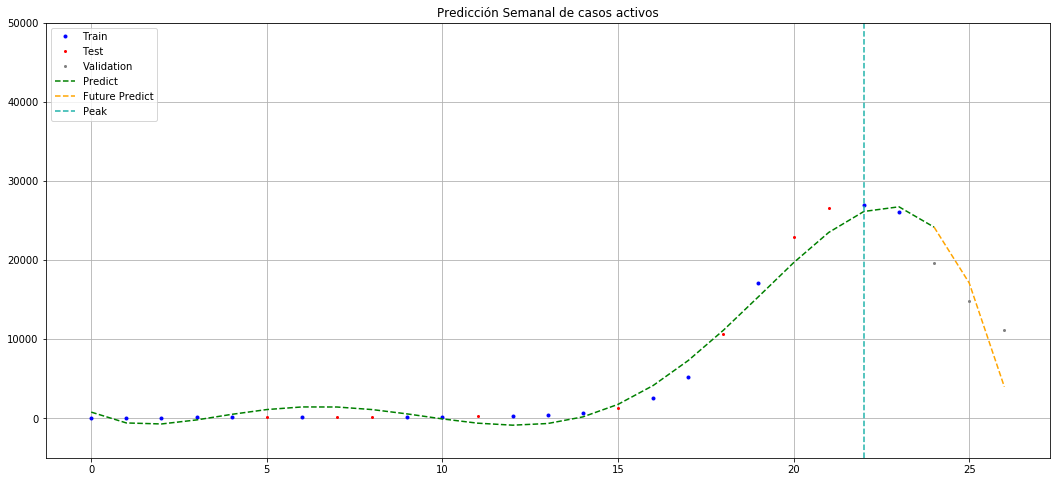

In [262]:
f = plt.figure(figsize=(18,8))
plt.title('Predicción Semanal de casos activos')
plt.grid()
plt.plot(X_train[X_train.flatten().argsort(),0],y_train[X_train.flatten().argsort(),0],'ob',markersize=3,label='Train')
plt.plot(X_test[X_test.flatten().argsort(),0],y_test[X_test.flatten().argsort(),0],'or',markersize=2,label='Test')
plt.plot(X_v,y_v,'o',color='gray',markersize=2,label='Validation')
plt.plot(x_pred_future[0:totalW-2],y_pred_future[0:totalW-2],'--g',label='Predict')
plt.plot(x_pred_future[totalW-3:],y_pred_future[totalW-3:],'--',color='orange',label='Future Predict')
plt.plot([22,22],[-5000,50000],'--',color='lightseagreen', label='Peak') #Peak of cases.
plt.ylim(-5000,50000)
plt.legend(loc='upper left');

In [263]:
y_pred_val = pipe.predict(X_v)
print('     ---- Métricas ----')
print('Total RMSE:\t\t{:.0f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('Total MAE:\t\t{:.0f}'.format(mean_absolute_error(y_test,y_pred)))
print('Future (3 weeks) RMSE:\t{:.0f}'.format(np.sqrt(mean_squared_error(y_v, y_pred_val))))
print('Future (3 weeks) MAE:\t{:.0f}'.format(mean_absolute_error(y_v,y_pred_val)))

     ---- Métricas ----
Total RMSE:		1744
Total MAE:		1402
Future (3 weeks) RMSE:	5077
Future (3 weeks) MAE:	4660


### Recuperados

In [218]:
totalW = len(dfMED_w.index.values)
X = dfMED_w.index.values[0:totalW-3].reshape(-1,1) #Variable independiente.
y = dfMED_w['acumulado_recuperados'].values[0:totalW-3].reshape(-1,1) #Variable dependiente.
#Datos de validación - nunca entran al modelo.
X_v = dfMED_w.index.values[totalW-3:].reshape(-1,1)
y_v = dfMED_w['acumulado_recuperados'].values[totalW-3:].reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123,shuffle=True)
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(degree=5),Lasso(random_state=123,max_iter=10000))
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=5, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lasso',
                 Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=10000, normalize=False, positive=False,
                       precompute=False, random_state=123, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [219]:
y_pred = pipe.predict(X_test)
x_pred_future = np.arange(0,totalW,step=1)
y_pred_future = pipe.predict(x_pred_future.reshape(-1,1))

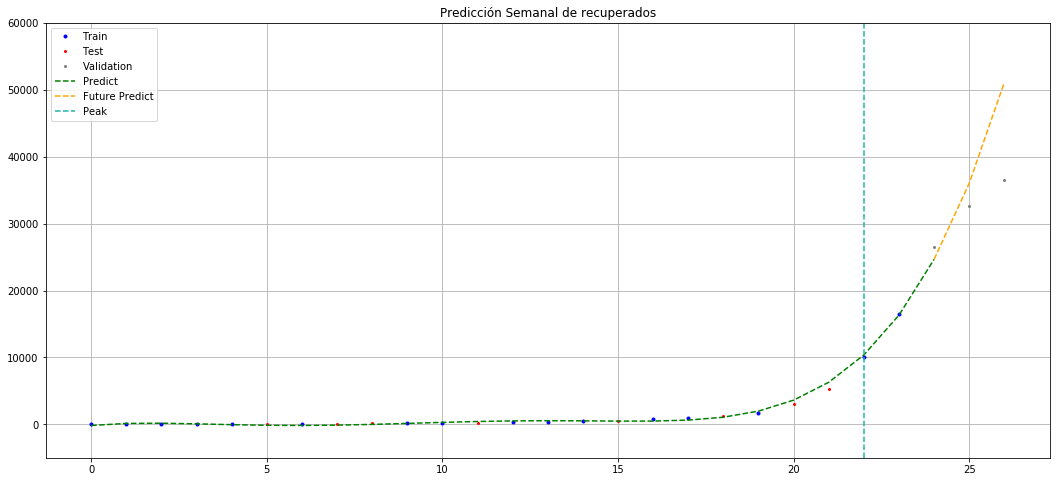

In [227]:
#Graph ordered data.
f = plt.figure(figsize=(18,8))
plt.title('Predicción Semanal de recuperados')
plt.grid()
plt.plot(X_train[X_train.flatten().argsort(),0],y_train[X_train.flatten().argsort(),0],'ob',markersize=3,label='Train')
plt.plot(X_test[X_test.flatten().argsort(),0],y_test[X_test.flatten().argsort(),0],'or',markersize=2,label='Test')
plt.plot(X_v,y_v,'o',color='gray',markersize=2,label='Validation')
plt.plot(x_pred_future[0:totalW-2],y_pred_future[0:totalW-2],'--g',label='Predict')
plt.plot(x_pred_future[totalW-3:],y_pred_future[totalW-3:],'--',color='orange',label='Future Predict')
plt.plot([22,22],[-5000,60000],'--',color='lightseagreen', label='Peak') #Peak of cases.
plt.ylim(-5000,60000)
plt.legend(loc='upper left');

In [224]:
y_pred_val = pipe.predict(X_v)
print('     ---- Métricas ----')
print('Total RMSE:\t\t{:.0f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('Total MAE:\t\t{:.0f}'.format(mean_absolute_error(y_test,y_pred)))
print('Future (3 weeks) RMSE:\t{:.0f}'.format(np.sqrt(mean_squared_error(y_v, y_pred_val))))
print('Future (3 weeks) MAE:\t{:.0f}'.format(mean_absolute_error(y_v,y_pred_val)))

     ---- Métricas ----
Total RMSE:		426
Total MAE:		327
Future (3 weeks) RMSE:	8706
Future (3 weeks) MAE:	6591


### Muertos

In [214]:
totalW = len(dfMED_w.index.values)
X = dfMED_w.index.values[0:totalW-3].reshape(-1,1) #Variable independiente.
y = dfMED_w['acumulado_muertos'].values[0:totalW-3].reshape(-1,1) #Variable dependiente.
#Datos de validación - nunca entran al modelo.
X_v = dfMED_w.index.values[totalW-3:].reshape(-1,1)
y_v = dfMED_w['acumulado_muertos'].values[totalW-3:].reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123,shuffle=True)
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(degree=7),Lasso(random_state=123,max_iter=10000))
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=7, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lasso',
                 Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=10000, normalize=False, positive=False,
                       precompute=False, random_state=123, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [215]:
y_pred = pipe.predict(X_test)
x_pred_future = np.arange(0,totalW,step=1)
y_pred_future = pipe.predict(x_pred_future.reshape(-1,1))

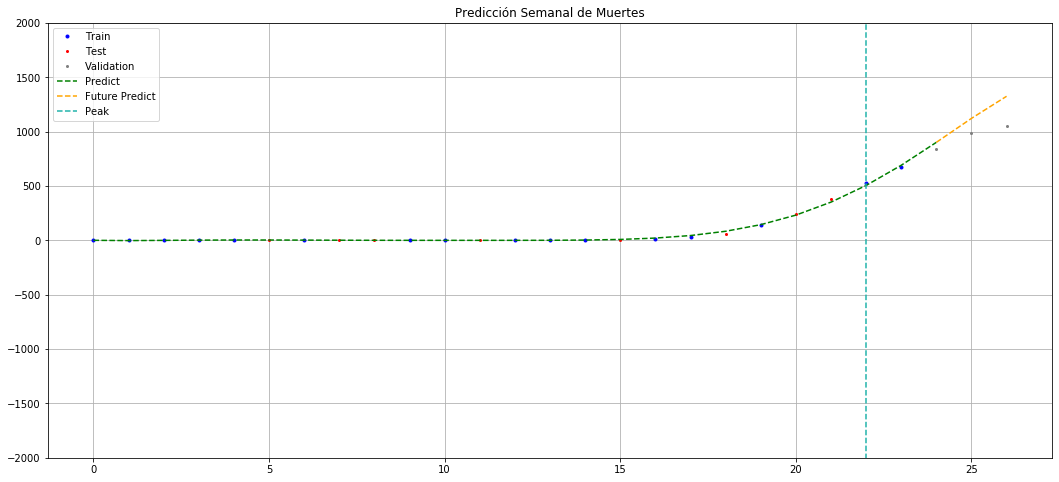

In [216]:
#Graph ordered data.
f = plt.figure(figsize=(18,8))
plt.title('Predicción Semanal de Muertes')
plt.grid()
plt.plot(X_train[X_train.flatten().argsort(),0],y_train[X_train.flatten().argsort(),0],'ob',markersize=3,label='Train')
plt.plot(X_test[X_test.flatten().argsort(),0],y_test[X_test.flatten().argsort(),0],'or',markersize=2,label='Test')
plt.plot(X_v,y_v,'o',color='gray',markersize=2,label='Validation')
plt.plot(x_pred_future[0:totalW-2],y_pred_future[0:totalW-2],'--g',label='Predict')
plt.plot(x_pred_future[totalW-3:],y_pred_future[totalW-3:],'--',color='orange',label='Future Predict')
plt.plot([22,22],[-5000,5000],'--',color='lightseagreen', label='Peak') #Peak of cases.
plt.ylim(-2000,2000)
plt.legend(loc='upper left');

In [204]:
y_pred_val = pipe.predict(X_v)
print('     ---- Métricas ----')
print('Total RMSE:\t\t{:.0f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('Total MAE:\t\t{:.0f}'.format(mean_absolute_error(y_test,y_pred)))
print('Future (3 weeks) RMSE:\t{:.0f}'.format(np.sqrt(mean_squared_error(y_v, y_pred_val))))
print('Future (3 weeks) MAE:\t{:.0f}'.format(mean_absolute_error(y_v,y_pred_val)))

     ---- Métricas ----
Total RMSE:		13
Total MAE:		9
Future (3 weeks) RMSE:	182
Future (3 weeks) MAE:	159
